# Preperation

### Imports

In [1]:
import os
import sys
from transformers import DataCollatorWithPadding
import torch
from sklearn.metrics import confusion_matrix

In [2]:
sys.path.append(os.path.abspath('../../src'))

from model_training import bert
from helper_functions import visualization as visual

### Paths

In [3]:
structure, output_dir, log_dir = bert.setup_paths()

Project Root: c:\Users\ilian\Documents\Projects\git_projects\university\phishing_detection


In [4]:
preprocessed_mail_data = structure.data.preprocessed.data_for_bert.combined_for_bert_csv
#preprocessed_mail_data = structure.data.preprocessed.Phishing_Email_csv
raw_mail_data = structure.data.raw.raw_combined_csv

# Training

### Train config

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [6]:
config = {
    'data_amount': 10000,
    'max_len': 512,
    'batch_size': 64,
    'num_epochs': 10,
    'learning_rate': 2e-05,
    'lr_scheduler_type': "linear",
    'weight_decay': 0.01,
    'logging_steps': 10,
    'evaluation_strategy': "epoch",
    'save_strategy': "epoch",
    'warmup_steps': 500,
    'early_stopping_patience': 3,
}

In [54]:
bert_type = 'distilbert-base-uncased' # 'bert-base-uncased' # distilbert-base-uncased

### Get model and tokenizer

In [8]:
special_tokens = ["[TIME]", "[DATE]", "[EMAIL]", "[URL]"]
#special_tokens = None

In [9]:
model, tokenizer = bert.create_model_and_tokenizer(bert_type, special_tokens, device)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
The new embeddings will be initialized from a multivariate normal distribution that has old embeddings' mean and covariance. As described in this article: https://nlp.stanford.edu/~johnhew/vocab-expansion.html. To disable this, use `mean_resizing=False`


Tokenizer vocabulary size: 30526


In [10]:
optimizer = torch.optim.AdamW(
    model.parameters(), 
    lr=config['learning_rate'], 
    betas=(0.9, 0.999), 
    eps=1e-08
)

scheduler = None 

### Prepare data

In [11]:
mail_data = bert.load_data(structure, config['data_amount'])


=== Updated Class Distribution ===
label
1    5300
0    4700
Name: count, dtype: int64 



In [12]:
train_data, eval_data, test_data = bert.split_data(mail_data, test_size=0.2, eval_size=0.2)
train_data.head(5)

Training data size: 6400
Evaluation data size: 1600
Test data size: 2000


,label,text
2840,0,re fwd re[2] [ilug] new ilug commitee [SEP] on...
3739,0,re [perl 46557] perl system command trouble wi...
8094,1,get your prescript ion delivered to your door ...
5096,1,patrick invites you to play! [SEP] be with me ...
6657,1,enjoy safe and convinient shopping for meds. [...


In [13]:
train_dataset, eval_dataset, test_dataset = bert.create_custom_datasets(
    train_data, eval_data, test_data, tokenizer, config['max_len']
)

In [14]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

### Verify preprocess

In [15]:
for i in range(5):
    sample = train_dataset[i]
    print(f"Sample {i}:")
    print("Input IDs:", sample["input_ids"])
    print("Attention Mask:", sample["attention_mask"])
    print("Label:", sample["labels"])
    print("-" * 40)

Sample 0:
Input IDs: tensor([  101,  2128,  1042, 21724,  2128,  1031,  1016,  1033,  1031,  6335,
        15916,  1033,  2047,  6335, 15916, 10797,  4402,   102,  2006, 30523,
         1010, 10805,  7104,  2626,  1996,  2755,  2008,  1037,  6565,  2193,
         1997,  2111,  2024,  2025,  2069,  5627,  2021,  4593,  2215,  2000,
         2175,  2006,  1996,  6335, 15916,  2837,  3849,  2000,  2033, 12590,
         2000,  1996,  2204,  1998,  1037,  2735,  2039,  2005,  1996,  2808,
         1010,  6195,  6335, 15916,  2001,  2006,  1996,  2391,  1997,  2331,
         1016,  2030,  1017,  2086,  3283,  1012,  1996,  2972,  2391,  1997,
         2026,  2434, 14739,  2001,  2000,  2391,  2041,  2000,  1996,  3738,
         1998,  1996,  2372,  1997,  1996, 11320,  2290,  2008,  1996,  2837,
         2004,  2623,  2011, 10958,  7507,  2884, 12621,  2001,  2025,  2008,
         3252, 16714,  2011,  1996,  4552,  1997,  1996,  6335, 15916,  1010,
         1998,  2008,  2056,  4552,  2018, 

In [16]:
for i in range(5):
    print(f"Sample {i}:")
    print("Input IDs length:", len(train_dataset[i]['input_ids']))
    print("Attention Mask length:", len(train_dataset[i]['attention_mask']))
    print("Label:", train_dataset[i]['labels'])
    print("-" * 40)


Sample 0:
Input IDs length: 512
Attention Mask length: 512
Label: tensor(0)
----------------------------------------
Sample 1:
Input IDs length: 512
Attention Mask length: 512
Label: tensor(0)
----------------------------------------
Sample 2:
Input IDs length: 512
Attention Mask length: 512
Label: tensor(1)
----------------------------------------
Sample 3:
Input IDs length: 512
Attention Mask length: 512
Label: tensor(1)
----------------------------------------
Sample 4:
Input IDs length: 512
Attention Mask length: 512
Label: tensor(1)
----------------------------------------


### Train model

In [ ]:
trainer = bert.train_evaluate(model, tokenizer, train_dataset, eval_dataset, config, data_collator, output_dir, log_dir)

### Load model

In [17]:
model, tokenizer = bert.load_model_from_checkpoint(output_dir, '400', device)

Model loaded from c:\Users\ilian\Documents\Projects\git_projects\university\phishing_detection\models\bert\checkpoint-400 onto cpu.


### Evaluate on Test

In [18]:
true_labels, predicted_labels, probs = bert.evaluate_on_test(model, test_dataset, data_collator, config['batch_size'], device)

# Visualization

### Extract metrics

In [19]:
metrics = visual.extract_all_metrics_from_events(log_dir)
extracted_metrics = visual.extract_loss_and_accuracy_metrics(metrics)

Existing Metrics Key Paths:
train - loss - steps
train - loss - values
train - grad_norm - steps
train - grad_norm - values
train - learning_rate - steps
train - learning_rate - values
train - epoch - steps
train - epoch - values
train - train_loss - steps
train - train_loss - values
train - train_accuracy - steps
train - train_accuracy - values
train - train_precision - steps
train - train_precision - values
train - train_recall - steps
train - train_recall - values
train - train_runtime - steps
train - train_runtime - values
train - train_samples_per_second - steps
train - train_samples_per_second - values
train - train_steps_per_second - steps
train - train_steps_per_second - values
eval - loss - steps
eval - loss - values
eval - accuracy - steps
eval - accuracy - values
eval - precision - steps
eval - precision - values
eval - recall - steps
eval - recall - values
eval - runtime - steps
eval - runtime - values
eval - samples_per_second - steps
eval - samples_per_second - values
eva

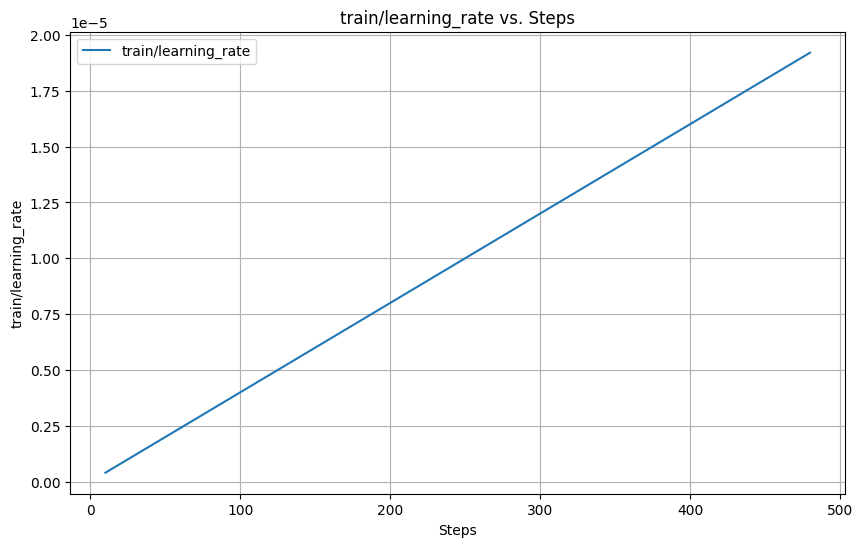

In [20]:
scalar_tag = "train/learning_rate"
visual.plot_scalar_metric(log_dir, scalar_tag)

### Loss x Epochs & Accuracy x Epochs

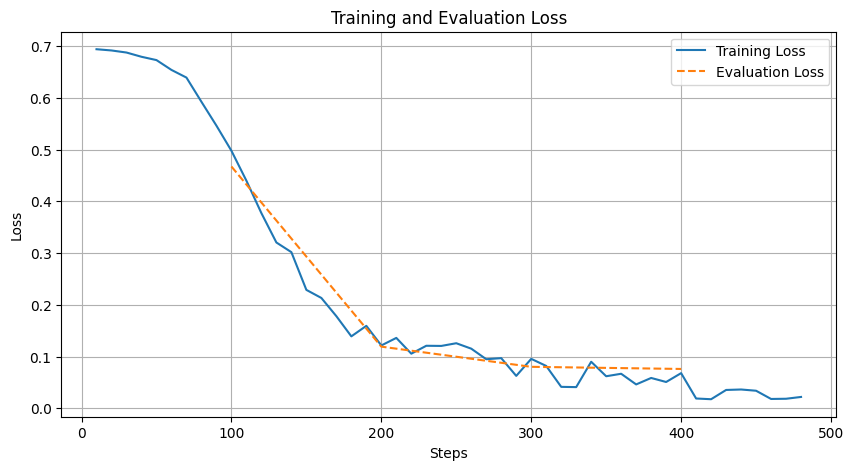

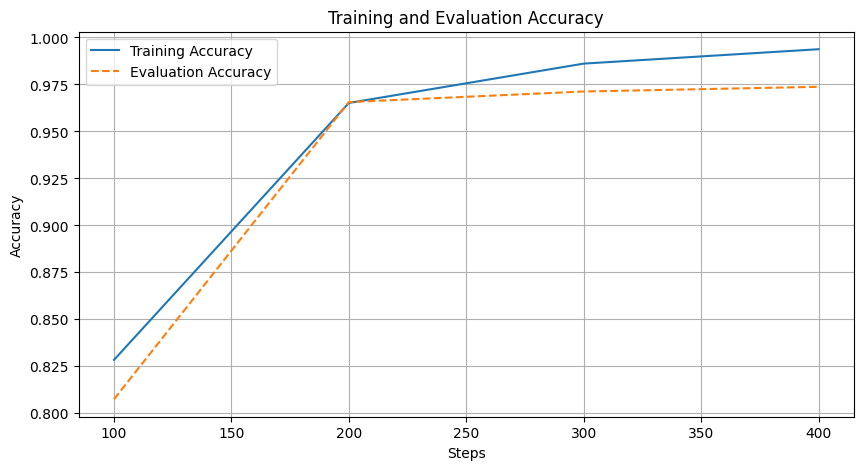

In [21]:
visual.plot_loss_accuracy(extracted_metrics, output_dir)

### Confusion Matrix

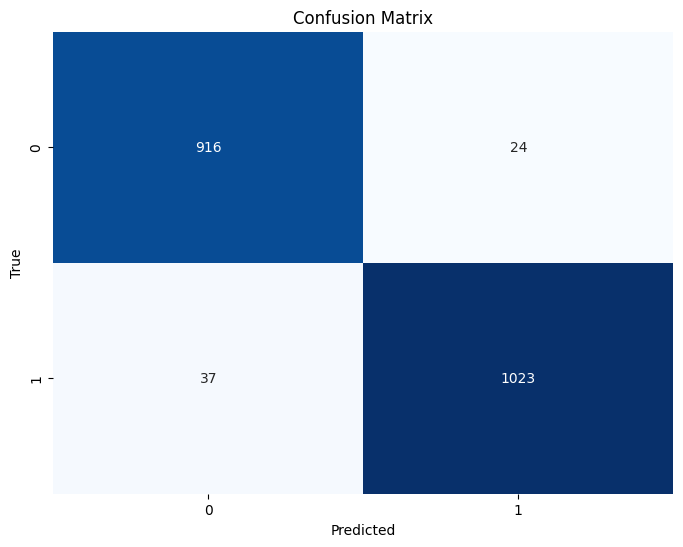

In [22]:
cm = confusion_matrix(true_labels, predicted_labels)
visual.plot_confusion_matrix(cm, output_dir, "test")

### ROC

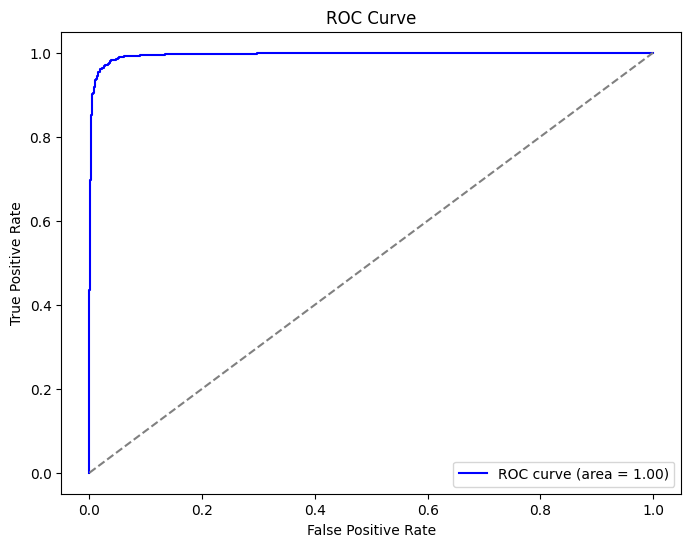

In [23]:
visual.plot_roc_curve(true_labels, probs, output_dir)

### Precision - Recall

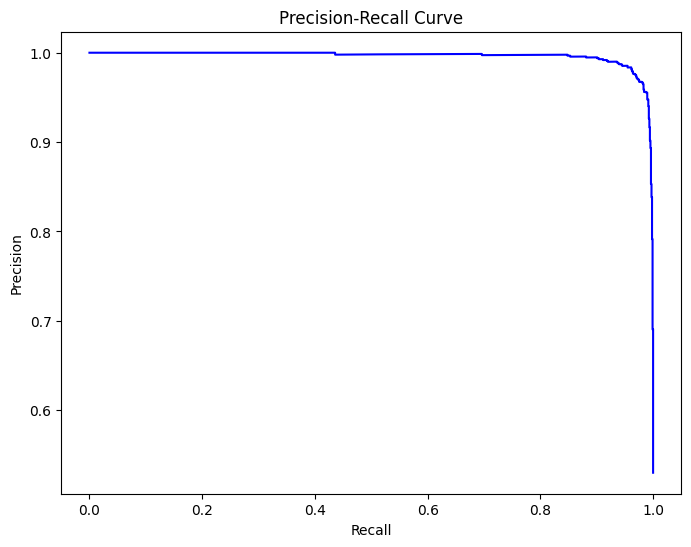

In [24]:
visual.plot_precision_recall(true_labels, probs, output_dir)

### Classification Report

In [25]:
visual.display_classification_report(true_labels, predicted_labels, target_names=["Legitimate", "Phishing"])

,precision,recall,f1-score,support
Legitimate,0.961175,0.974468,0.967776,940.0000
Phishing,0.977077,0.965094,0.971049,1060.0000
accuracy,0.969500,0.969500,0.969500,0.9695
macro avg,0.969126,0.969781,0.969412,2000.0000
weighted avg,0.969603,0.969500,0.969511,2000.0000


### Inference on samples

In [50]:
s_texts = [
    # Legitimate (0) - Customer addressed with name
    "Dear Frank, your shipment is on its way. Track your order with the tracking number 1234567890. Thank you for shopping with us!",
    
    # Phishing (1) - Generic addressing with urgency
    "Dear user, urgent: Your shipment is delayed. Track your order immediately by clicking this link and providing personal details.",
    
    # Legitimate (0) - Shipment tracking with a proper number
    "Your package has been shipped and is expected to arrive tomorrow. Use the tracking number 9876543210 to track your order in real time.",
    
    # Phishing (1) - Phishing attempt with urgency and a vague request
    "Urgent! Your package has been delayed. Click here to provide your personal information and confirm your tracking number to avoid further delays.",
    
    # Legitimate (0) - Monthly bank statement review
    "Dear Frank, your monthly bank statement is available for review. Please log in to your account to view the full details.",
    
    # Phishing (1) - Urgent account compromise message
    "Your bank account has been compromised! Click this link immediately to verify your identity and secure your account before any further issues occur.",
    
    # Legitimate (0) - Real job application confirmation
    "Hello Frank, we have received your application for the software engineering position. Our team will review it and contact you within a week.",
    
    # Phishing (1) - Fake job application attempt
    "Congratulations, Frank! You've been shortlisted for a job. Please provide your personal information to finalize your application process.",
    
    # Legitimate (0) - Real company promotion (e.g., Easter gift)
    "Happy Easter, Frank! Enjoy a special 15% discount on your next purchase at our store. Use the promo code EASTER15.",
    
    # Phishing (1) - Fake prize scam
    "Congratulations! You've won a $1,000 gift card. To claim your prize, please provide your bank details here."
]

s_true_labels = [
    0, 1, 0, 1, 0, 1, 0, 1, 0, 1
]


In [51]:
s_true_labels, s_predicted_labels, s_probs = bert.inference(
    model, s_texts, s_true_labels, tokenizer,  config['max_len'], device
)

In [52]:
visual.display_inference_results(s_texts, s_true_labels, s_predicted_labels, s_probs, class_names=["Legitimate", "Phishing"])


---- Model Predictions ----

Text: Dear Frank, your shipment is on its way. Track your order with the tracking number 1234567890. Thank you for shopping with us!
True Label: Legitimate
Pred Label: Phishing
     Probs: Legitimate: 0.07, Phishing: 0.93

------------------------------------------------------------

Text: Dear user, urgent: Your shipment is delayed. Track your order immediately by clicking this link and providing personal details.
True Label: Phishing
Pred Label: Phishing
     Probs: Legitimate: 0.01, Phishing: 0.99

------------------------------------------------------------

Text: Your package has been shipped and is expected to arrive tomorrow. Use the tracking number 9876543210 to track your order in real time.
True Label: Legitimate
Pred Label: Phishing
     Probs: Legitimate: 0.01, Phishing: 0.99

------------------------------------------------------------

Text: Urgent! Your package has been delayed. Click here to provide your personal information and confirm you

In [53]:
visual.display_classification_report(s_true_labels, s_predicted_labels, target_names=["Legitimate", "Phishing"])

,precision,recall,f1-score,support
Legitimate,0.5,0.2,0.285714,5.0
Phishing,0.5,0.8,0.615385,5.0
accuracy,0.5,0.5,0.500000,0.5
macro avg,0.5,0.5,0.450549,10.0
weighted avg,0.5,0.5,0.450549,10.0
